# Generative Classification

### Preliminaries

- Goal 
  - Introduction to linear generative classification with a Gaussian-categorical generative model
  
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 196-202 (section 4.2 focusses on binary classification, whereas in these lecture notes we describe generative classification for multiple classes).    

### Challenge: an apple or a peach?

- **Problem**: You're given numerical values for the skin features roughness and color for 200 pieces of fruit, where for each piece of fruit you also know if it is an apple or a peach. Now you receive the roughness and color values for a new piece of fruit but you don't get its class label (apple or peach). What is the probability that the new piece is an apple?

- **Solution**: To be solved later in this lesson.

-  Let's first generate a data set (see next slide).

In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate();
using IJulia; try IJulia.clear_output(); catch _ end

  Activating project at `~/github/bertdv/BMLIP/lessons`


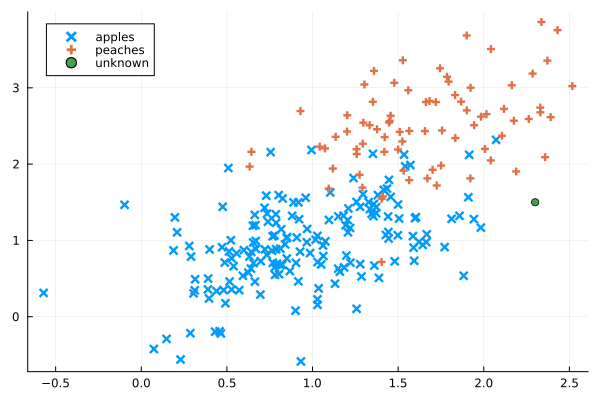

In [2]:
using Plots, Distributions

N = 250; p_apple = 0.7; Σ = [0.2 0.1; 0.1 0.3]
p_given_apple = MvNormal([1.0, 1.0], Σ) # p(X|y=apple)
p_given_peach = MvNormal([1.7, 2.5], Σ) # p(X|y=peach)
X = Matrix{Float64}(undef,2,N); y = Vector{Bool}(undef,N) # true corresponds to apple
for n=1:N
    y[n] = (rand() < p_apple) # Apple or peach?
    X[:,n] = y[n] ? rand(p_given_apple) : rand(p_given_peach) # Sample features
end
X_apples = X[:,findall(y)]'; X_peaches = X[:,findall(.!y)]' # Sort features on class
x_test = [2.3; 1.5] # Features of 'new' data point

scatter(X_apples[:,1], X_apples[:,2], label="apples", marker=:x, markerstrokewidth=3)   # apples
scatter!(X_peaches[:,1], X_peaches[:,2], label="peaches", marker=:+,  markerstrokewidth=3) # peaches
scatter!([x_test[1]], [x_test[2]], label="unknown")           # 'new' unlabelled data point


### Generative Classification Problem Statement

- Given is a data set  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$
  - inputs $x_n \in \mathbb{R}^M$ are called **features**.
  - outputs $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$; The **discrete** targets $\mathcal{C}_k$ are called **classes**.

- We will again use the 1-of-$K$ notation for the discrete classes. Define the binary **class selection variable**
$$
y_{nk} = \begin{cases} 1 & \text{if  } \, y_n \in \mathcal{C}_k\\
0 & \text{otherwise} \end{cases}
$$
  - (Hence, the notations $y_{nk}=1$ and $y_n \in \mathcal{C}_k$ mean the same thing.)

-  The plan for generative classification: build a model for the joint pdf $p(x,y)= p(x|y)p(y)$ and use Bayes to infer the posterior class probabilities 

$$
p(y|x) = \frac{p(x|y) p(y)}{\sum_{y^\prime} p(x|y^\prime) p(y^\prime)} \propto p(x|y)\,p(y)
$$

###  1 - Model specification 

##### Likelihood

- Assume Gaussian **class-conditional distributions** with **equal covariance matrix** across the classes,
 $$
 p(x_n|\mathcal{C}_{k}) = \mathcal{N}(x_n|\mu_k,\Sigma)
 $$
with notational shorthand: $\mathcal{C}_{k} \triangleq (y_n \in \mathcal{C}_{k})$.

##### Prior

- We use a categorical distribution for the class labels $y_{nk}$: 
$$p(\mathcal{C}_{k}) = \pi_k$$



- Hence, using the one-hot coding formulation for $y_{nk}$, the generative model $p(x_n,y_n)$ can be written as

$$\begin{align*}
 p(x_n,y_n) &= \prod_{k=1}^K p(x_n,y_{nk}=1)^{y_{nk}} \\
   &= \prod_{k=1}^K \left( \pi_k \cdot\mathcal{N}(x_n|\mu_k,\Sigma)\right)^{y_{nk}}
\end{align*}$$


- We will refer to this model as the **Gaussian-Categorical Model** (<a id="GCM">GCM</a>). 
  - N.B. In the literature, this model (with possibly unequal $\Sigma_k$ across classes) is often called the Gaussian Discriminant Analysis  model and the special case with equal covariance matrices $\Sigma_k=\Sigma$ is also called Linear Discriminant Analysis. We think these names are a bit unfortunate as it may lead to confusion with the [discriminative method for classification](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Discriminative-Classification.ipynb).

- As usual, once the model has been specified, the rest (inference for parameters and model prediction) through straight probability theory.

### Computing the log-likelihood

- The <a id="generative-classification-llh">log-likelihood</a> given the full data set $D=\{(x_n,y_n), n=1,2,\ldots,N\}$ is then
$$\begin{align*}
\log\, p(D|\theta) &\stackrel{\text{IID}}{=} \sum_n \log \prod_k p(x_n,y_{nk}=1\,|\,\theta)^{y_{nk}}  \\
  &=  \sum_{n,k} y_{nk} \log p(x_n,y_{nk}=1\,|\,\theta) \\
     &=  \sum_{n,k} y_{nk}  \log p(x_n|y_{nk}=1)  +  \sum_{n,k} y_{nk} \log p(y_{nk}=1) \\
   &=  \sum_{n,k} y_{nk}  \log\mathcal{N}(x_n|\mu_k,\Sigma)  +  \sum_{n,k} y_{nk} \log \pi_k \\
   &=  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{see Gaussian est.} } + \underbrace{ \sum_k m_k \log \pi_k }_{ \text{see multinomial est.} } 
\end{align*}$$
where we used $m_k \triangleq \sum_n y_{nk}$.

### 2 -  Parameter Inference for Classification

- We'll do Maximum Likelihood estimation for $\theta = \{ \pi_k, \mu_k, \Sigma \}$ from data $D$

-  Recall (from the previous slide) the log-likelihood (LLH)

$$
\log\, p(D|\theta) =  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{Gaussian} } + \underbrace{ \sum_k m_k \log \pi_k }_{ \text{multinomial} } 
$$

- Maximization of the LLH for the GDA model breaks down into
  -  **Gaussian density estimation** for parameters $\mu_k, \Sigma$, since the first term contains exactly the log-likelihood for MVG density estimation. We've already done this, see the [Gaussian distribution lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/The-Gaussian-Distribution.ipynb#ML-for-Gaussian).
  - **Multinomial density estimation** for class priors $\pi_k$, since the second term holds exactly the log-likelihood for multinomial density estimation, see the [Multinomial distribution lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/The-Multinomial-Distribution.ipynb#ML-for-multinomial). 
 

 - The ML for multinomial class prior (we've done this before!)
$$\begin{align*}   
\hat \pi_k = \frac{m_k}{N} 
\end{align*}$$

- Now group the data into separate classes and do MVG ML estimation for class-conditional parameters (we've done this before as well):
$$\begin{align*}
 \hat \mu_k &= \frac{ \sum_n y_{nk} x_n} { \sum_n y_{nk} } = \frac{1}{m_k} \sum_n y_{nk} x_n \\
 \hat \Sigma  &= \frac{1}{N} \sum_{n,k} y_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T \\
  &= \sum_k \hat \pi_k \cdot \underbrace{ \left( \frac{1}{m_k} \sum_{n} y_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T  \right) }_{ \text{class-cond. variance} } \\
  &= \sum_k \hat \pi_k \cdot \hat \Sigma_k
\end{align*}$$
where $\hat \pi_k$, $\hat{\mu}_k$ and $\hat{\Sigma}_k$ are the sample proportion, sample mean and sample variance for the $k$th class, respectively.

- Note that the binary class selection variable $y_{nk}$ groups data from the same class.

###  3 - Application: Class prediction for new Data

-  Let's apply the trained model to predict the class for given a 'new' input $x_\bullet$:
$$\begin{align*}
p(\mathcal{C}_k|x_\bullet,D ) &= \int p(\mathcal{C}_k|x_\bullet,\theta ) \underbrace{p(\theta|D)}_{\text{ML: }\delta(\theta - \hat{\theta})} \mathrm{d}\theta \\
&= p(\mathcal{C}_k|x_\bullet,\hat{\theta} ) \\
&\propto p(\mathcal{C}_k)\,p(x_\bullet|\mathcal{C}_k) \\
&= \hat{\pi}_k \cdot \mathcal{N}(x_\bullet | \hat{\mu}_k, \hat{\Sigma}) \\
  &\propto \hat{\pi}_k \exp \left\{ { - {\frac{1}{2}}(x_\bullet - \hat{\mu}_k )^T \hat{\Sigma}^{ - 1} (x_\bullet - \hat{\mu}_k )} \right\}\\
  &=\exp \Big\{ \underbrace{-\frac{1}{2}x_\bullet^T \hat{\Sigma}^{ - 1} x_\bullet}_{\text{not a function of }k} + \hat{\mu}_k^T \hat{\Sigma}^{-1} x_\bullet - {\frac{1}{2}}\hat{\mu}_k^T \hat{\Sigma}^{ - 1} \hat{\mu}_k  + \log \hat{\pi}_k  \Big\}  \\
  &\propto  \frac{1}{Z}\exp\{\beta_k^T x_\bullet + \gamma_k\} \\
  &\triangleq \sigma\left( \beta_k^T x_\bullet + \gamma_k\right)
\end{align*}$$
where 
$\sigma(a_k) \triangleq \frac{\exp(a_k)}{\sum_{k^\prime}\exp(a_{k^\prime})}$ is called a [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) (a.k.a. **normalized exponential**) function, and
$$\begin{align*}
\beta_k &= \hat{\Sigma}^{-1} \hat{\mu}_k \\
\gamma_k &= - \frac{1}{2} \hat{\mu}_k^T \hat{\Sigma}^{-1} \hat{\mu}_k  + \log \hat{\pi}_k \\
Z &= \sum_{k^\prime}\exp\{\beta_{k^\prime}^T x_\bullet + \gamma_{k^\prime}\}\,. \quad \text{(normalization constant)} 
\end{align*}$$

- The softmax function is a smooth approximation to the max-function. Note that we did not a priori specify a softmax posterior, but rather it followed from applying Bayes rule to the prior and likelihood assumptions. 

- Note the following properties of the softmax function $\sigma(a_k)$:
  - $\sigma(a_k)$ is monotonicaly ascending function and hence it preserves the order of $a_k$. That is, if $a_j>a_k$ then $\sigma(a_j)>\sigma(a_k)$. 
  - $\sigma(a_k)$ is always a proper probability distribution, since $\sigma(a_k)>0$ and $\sum_k \sigma(a_k) = 1$. 
  

###  Discrimination Boundaries

-  The class log-posterior $\log p(\mathcal{C}_k|x) \propto \beta_k^T x + \gamma_k$ is a linear function of the input features.

-  Thus, the contours of equal probability (**discriminant functions**) are lines (hyperplanes) in the feature space
$$
\log \frac{{p(\mathcal{C}_k|x,\theta )}}{{p(\mathcal{C}_j|x,\theta )}} = \beta_{kj}^T x + \gamma_{kj} = 0
$$
where we defined $\beta_{kj} \triangleq \beta_k - \beta_j$ and similarly for $\gamma_{kj}$.

-  How to classify a new input $x_\bullet$? The Bayesian answer is a posterior distribution $ p(\mathcal{C}_k|x_\bullet)$. If you must choose, then the class with maximum posterior class probability
$$\begin{align*}
k^* &= \arg\max_k p(\mathcal{C}_k|x_\bullet) \\
  &= \arg\max_k \left( \beta _k^T x_\bullet + \gamma_k \right)
\end{align*}$$
is an appealing decision. 

### <a id="code-generative-classification-example">Code Example</a>:  Working out the "apple or peach" example problem

We'll apply the above results to solve the "apple or peach" example problem.

p(apple|x=x∙) = 0.758239422055906


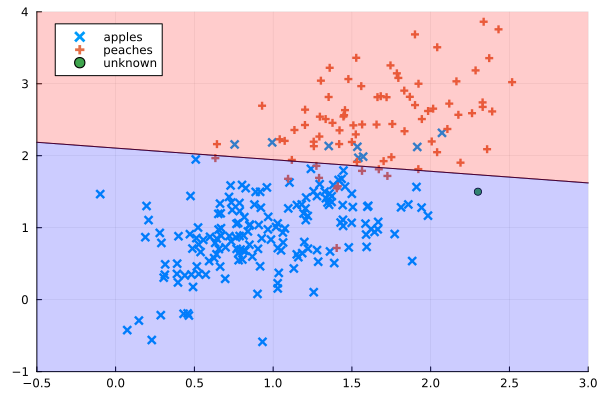

In [3]:
# Make sure you run the data-generating code cell first
using Distributions, Plots
# Multinomial (in this case binomial) density estimation
p_apple_est = sum(y.==true) / length(y)
π_hat = [p_apple_est; 1-p_apple_est]

# Estimate class-conditional multivariate Gaussian densities
d1 = fit_mle(FullNormal, X_apples')  # MLE density estimation d1 = N(μ₁, Σ₁)
d2 = fit_mle(FullNormal, X_peaches') # MLE density estimation d2 = N(μ₂, Σ₂)
Σ = π_hat[1]*cov(d1) + π_hat[2]*cov(d2) # Combine Σ₁ and Σ₂ into Σ
conditionals = [MvNormal(mean(d1), Σ); MvNormal(mean(d2), Σ)] # p(x|C)

# Calculate posterior class probability of x∙ (prediction)
function predict_class(k, X) # calculate p(Ck|X)
    norm = π_hat[1]*pdf(conditionals[1],X) + π_hat[2]*pdf(conditionals[2],X)
    return π_hat[k]*pdf(conditionals[k], X) ./ norm
end
println("p(apple|x=x∙) = $(predict_class(1,x_test))")

# Discrimination boundary of the posterior (p(apple|x;D) = p(peach|x;D) = 0.5)
β(k) = inv(Σ)*mean(conditionals[k])
γ(k) = -0.5 * mean(conditionals[k])' * inv(Σ) * mean(conditionals[k]) + log(π_hat[k])
function discriminant_x2(x1)
    # Solve discriminant equation for x2
    β12 = β(1) .- β(2)
    γ12 = (γ(1) .- γ(2))[1,1]
    return -1*(β12[1]*x1 .+ γ12) ./ β12[2]
end

scatter(X_apples[:,1], X_apples[:,2], label="apples", marker=:x, markerstrokewidth=3)   # apples
scatter!(X_peaches[:,1], X_peaches[:,2], label="peaches", marker=:+,  markerstrokewidth=3) # peaches
scatter!([x_test[1]], [x_test[2]], label="unknown")           # 'new' unlabelled data point

x1 = range(-1,length=10,stop=3)
plot!(x1, discriminant_x2(x1), color="black", label="") # Plot discrimination boundary
plot!(x1, discriminant_x2(x1), fillrange=-10, alpha=0.2, color=:blue, label="")
plot!(x1, discriminant_x2(x1), fillrange=10, alpha=0.2, color=:red, xlims=(-0.5, 3), ylims=(-1, 4), label="")

###  Recap Generative Classification

- Gaussian-Categorical Model specification:  

$$p(x,\mathcal{C}_k|\,\theta) = \pi_k \cdot \mathcal{N}(x|\mu_k,\Sigma)$$

- If the class-conditional distributions are Gaussian with equal covariance matrices across classes ($\Sigma_k = \Sigma$), then
    the discriminant functions are hyperplanes in feature space.

- ML estimation for $\{\pi_k,\mu_k,\Sigma\}$ in the GCM model breaks down to simple density estimation for Gaussian and multinomial/categorical distributions.

- Posterior class probability is a softmax function
$$ p(\mathcal{C}_k|x,\theta ) \propto \exp\{\beta_k^T x + \gamma_k\}$$
where $\beta _k= \Sigma^{-1} \mu_k$ and $\gamma_k=- \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k  + \log \pi_k$.

In [3]:
open("../../styles/aipstyle.html") do f
    display("text/html", read(f,String))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->